In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import cv2
import requests
import datetime

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical

Init Plugin
Init Graph Optimizer
Init Kernel


In [ ]:
# ! pip install kaggle # Install the Kaggle library
# ! mkdir ~/.kaggle    # Make a directory named “.kaggle”
# ! cp kaggle.json ~/.kaggle/ # Copy the “kaggle.json” into this new directory
# ! chmod 600 ~/.kaggle/kaggle.json # Allocate the required permission for this file.
# ! kaggle datasets download paultimothymooney/chest-xray-pneumonia
# ! unzip chest-xray-pneumonia.zip

In [3]:
# Generate Normal, Pneumonia data

img_size = 224
labels = ["NORMAL", "PNEUMONIA"]

def create_training_data(wd):
  traininig_data = []
  for label in labels:
    path = os.path.join(wd, label)
    class_num = labels.index(label) # assign label to data
    for img in os.listdir(path):

      try:
        img_array = cv2.imread(os.path.join(path, img)) # cv2.IMREAD_GRAYSCALE : 흑백으로 이미지 로드, IMREAD_COLOR 
        new_array = cv2.resize(img_array, (img_size,img_size))
        traininig_data.append([new_array, class_num])
      except:
          print("error file = ", path)
      # else:
        # print("Process Completed")
  return np.array(traininig_data, dtype=object)

In [4]:
# Normal vs. Pneumonia
train = create_training_data(os.getcwd()+'/chest_xray/train')
val = create_training_data(os.getcwd()+'/chest_xray/val')
test = create_training_data(os.getcwd()+'/chest_xray/test')

In [5]:
print(len(train), len(val), len(test))

5216 16 624


1
0
1


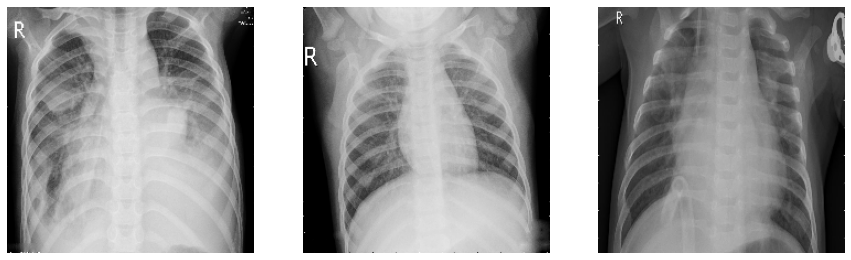

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,15))
ax[0].imshow(train[5000][0], cmap='gray')
print(train[5000][1])

ax[1].imshow(val[5][0], cmap='gray')
print(val[5][1])

ax[2].imshow(test[600][0], cmap='gray')
print(test[600][1])

ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off');

In [7]:
# Random_suffle : return None
np.random.shuffle(train)
np.random.shuffle(val)
np.random.shuffle(test)

In [8]:
X_train = []
y_train = []

for features, label in train:
  X_train.append(features)
  y_train.append(label)

X_val = []
y_val = []

for features, label in val:
  X_val.append(features)
  y_val.append(label)

X_test = []
y_test = []

for features, label in test:
  X_test.append(features)
  y_test.append(label)

# Convert to numpy array & Separate feature and label
#.reshape(-1,img_size, img_size, 1) --> 1 for gray_scale, 3 for colors (row, width, height, layer(color channel))

X_train = np.array(X_train).reshape(-1,img_size, img_size, 3) 
y_train = np.array(y_train)

X_val = np.array(X_val).reshape(-1,img_size, img_size, 3) 
y_val = np.array(y_val)

X_test = np.array(X_test).reshape(-1,img_size, img_size, 3) 
y_test = np.array(y_test)

In [9]:
X_train[0].shape, X_val[0].shape

((224, 224, 3), (224, 224, 3))

In [10]:
# Data Scaling -  Normalization
X_train_norm = X_train / 255
X_val_norm = X_val / 255
X_test_norm = X_test / 255

In [11]:
# Convert label to categorical data for better performance?
y_train_oh = to_categorical(y_train, num_classes=2)
y_val_oh = to_categorical(y_val, num_classes=2)
y_test_oh = to_categorical(y_test, num_classes=2)

In [12]:
y_train_oh.shape, y_val_oh.shape, y_test_oh.shape

((5216, 2), (16, 2), (624, 2))

In [18]:
# VGG 19 Model
class VGG19(Sequential):
    def __init__(self, input_shape):
        super().__init__()

        self.add(Conv2D(64, kernel_size=(3,3), padding= 'same',
                        activation= 'relu', input_shape= input_shape))
        self.add(Conv2D(64, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'))
        self.add(MaxPooling2D(pool_size=(2,2), strides= (2,2)))

        self.add(Conv2D(128, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'))
        self.add(Conv2D(128, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'))
        self.add(MaxPooling2D(pool_size=(2,2), strides= (2,2)))

        self.add(Conv2D(256, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'))
        self.add(Conv2D(256, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'))
        self.add(Conv2D(256, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'))
        self.add(Conv2D(256, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'))
        self.add(MaxPooling2D(pool_size=(2,2), strides= (2,2)))

        self.add(Conv2D(512, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'))
        self.add(Conv2D(512, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'))
        self.add(Conv2D(512, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'))
        self.add(Conv2D(512, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'))
        self.add(MaxPooling2D(pool_size=(2,2), strides= (2,2)))

        self.add(Conv2D(512, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'))
        self.add(Conv2D(512, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'))
        self.add(Conv2D(512, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'))
        self.add(Conv2D(512, kernel_size=(3,3), padding= 'same',
                        activation= 'relu'))
        self.add(MaxPooling2D(pool_size=(2,2), strides= (2,2)))

        self.add(Flatten())
        self.add(Dense(4096, activation= 'relu'))
        self.add(Dropout(0.5))
        self.add(Dense(4096, activation= 'relu'))
        self.add(Dropout(0.5))
        self.add(Dense(2, activation= 'sigmoid'))

        self.compile(optimizer= tf.keras.optimizers.Adam(0.003),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

In [19]:
model = VGG19((224, 224, 3))

In [20]:
model.summary()

Model: "vg_g19_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 56, 56, 256)       295

In [21]:
model.fit(X_train_norm, y_train_oh, 
          batch_size=512,
          epochs=1,
          validation_split=0.2)

2021-12-20 20:08:41.565970: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Insufficient Memory (00000008:kIOGPUCommandBufferCallbackErrorOutOfMemory)
	<AGXG13XFamilyCommandBuffer: 0x17552f5a0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebb0c00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x115a5d000>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebb0c00>
            name = Apple M1 Pro 
    retainedReferences = 1


1/9 [==>...........................] - ETA: 5:26 - loss: 0.6931 - accuracy: 0.2422

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Insufficient Memory (00000008:kIOGPUCommandBufferCallbackErrorOutOfMemory)
	<AGXG13XFamilyCommandBuffer: 0x1754b0180>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebb0c00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x115a5d000>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebb0c00>
            name = Apple M1 Pro 
    retainedReferences = 1


2/9 [=====>........................] - ETA: 3:48 - loss: 0.6923 - accuracy: 0.5176

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Insufficient Memory (00000008:kIOGPUCommandBufferCallbackErrorOutOfMemory)
	<AGXG13XFamilyCommandBuffer: 0x165f11720>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebb0c00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x115a5d000>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebb0c00>
            name = Apple M1 Pro 
    retainedReferences = 1


3/9 [=========>....................] - ETA: 3:14 - loss: 0.6917 - accuracy: 0.5859

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Insufficient Memory (00000008:kIOGPUCommandBufferCallbackErrorOutOfMemory)
	<AGXG13XFamilyCommandBuffer: 0x165f1c6d0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebb0c00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x115a5d000>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebb0c00>
            name = Apple M1 Pro 
    retainedReferences = 1


4/9 [============>.................] - ETA: 2:38 - loss: 0.6910 - accuracy: 0.6260

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Insufficient Memory (00000008:kIOGPUCommandBufferCallbackErrorOutOfMemory)
	<AGXG13XFamilyCommandBuffer: 0x175588a30>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebb0c00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x115a5d000>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebb0c00>
            name = Apple M1 Pro 
    retainedReferences = 1


5/9 [===============>..............] - ETA: 2:05 - loss: 0.6902 - accuracy: 0.6492

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Insufficient Memory (00000008:kIOGPUCommandBufferCallbackErrorOutOfMemory)
	<AGXG13XFamilyCommandBuffer: 0x1754b01f0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebb0c00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x115a5d000>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebb0c00>
            name = Apple M1 Pro 
    retainedReferences = 1


6/9 [===================>..........] - ETA: 1:32 - loss: 0.6896 - accuracy: 0.6624

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Insufficient Memory (00000008:kIOGPUCommandBufferCallbackErrorOutOfMemory)
	<AGXG13XFamilyCommandBuffer: 0x166fccef0>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebb0c00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x115a5d000>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebb0c00>
            name = Apple M1 Pro 
    retainedReferences = 1


7/9 [======================>.......] - ETA: 1:01 - loss: 0.6888 - accuracy: 0.6761

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Insufficient Memory (00000008:kIOGPUCommandBufferCallbackErrorOutOfMemory)
	<AGXG13XFamilyCommandBuffer: 0x165f41f60>
    label = <none> 
    device = <AGXG13XDevice: 0x15ebb0c00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x115a5d000>
        label = <none> 
        device = <AGXG13XDevice: 0x15ebb0c00>
            name = Apple M1 Pro 
    retainedReferences = 1


9/9 [==============================] - ETA: 0s - loss: 0.6881 - accuracy: 0.6843 

2021-12-20 20:13:00.980593: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 276s 29s/step - loss: 0.6881 - accuracy: 0.6843 - val_loss: 15.3847 - val_accuracy: 0.7241
